# ML Advanced Recap

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, classification_report

import shap

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df["target"] = data.target

print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (569, 31)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [3]:
selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(df[data.feature_names], df["target"])

selected_features = df[data.feature_names].columns[selector.get_support()].tolist()
print("Selected Features:", selected_features)

Selected Features: ['mean radius', 'mean perimeter', 'mean area', 'mean concavity', 'mean concave points', 'worst radius', 'worst perimeter', 'worst area', 'worst concavity', 'worst concave points']


In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[selected_features])

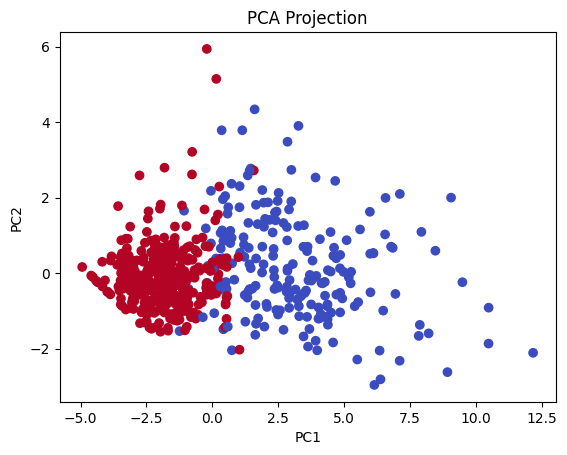

In [5]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df["target"], cmap='coolwarm')
plt.title("PCA Projection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, df["target"], test_size=0.2, random_state=42
)

In [7]:
param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [None, 5, 10]
}

rf = RandomForestClassifier(random_state=42)

grid = GridSearchCV(
    rf, param_grid, cv=3, scoring="accuracy", n_jobs=-1, verbose=1
)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print("Best Model:", best_model)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Model: RandomForestClassifier(max_depth=10, n_estimators=50, random_state=42)


In [8]:
y_pred = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9649122807017544

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.93      0.95        43
           1       0.96      0.99      0.97        71

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



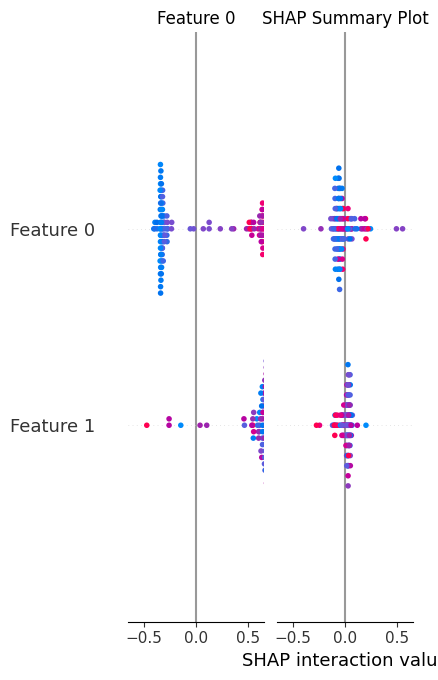

In [9]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values.values, X_test, show=False)
plt.title("SHAP Summary Plot")
plt.show()